# 환경설정

In [6]:
!pip install koreanize_matplotlib -q

import koreanize_matplotlib

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, root_mean_squared_log_error

In [9]:
site_path = r'/content/drive/MyDrive/코드잇_데이터분석_6기/99_프로젝트/03_중급프로젝트(공유오피스체험결제)/DATA/site_area.csv'
access_path = r'/content/drive/MyDrive/코드잇_데이터분석_6기/99_프로젝트/03_중급프로젝트(공유오피스체험결제)/DATA/trial_access_log.csv'
payment_path = r'/content/drive/MyDrive/코드잇_데이터분석_6기/99_프로젝트/03_중급프로젝트(공유오피스체험결제)/DATA/trial_payment.csv'
regist_path = r'/content/drive/MyDrive/코드잇_데이터분석_6기/99_프로젝트/03_중급프로젝트(공유오피스체험결제)/DATA/trial_register.csv'
visit_path = r'/content/drive/MyDrive/코드잇_데이터분석_6기/99_프로젝트/03_중급프로젝트(공유오피스체험결제)/DATA/trial_visit_info.csv'

# 데이터 확인

In [10]:
# 지점별 면적 테이블
area_df = pd.read_csv(site_path)
area_df.tail(15)

,site_id,area_pyeong
0,1,50
1,2,100
2,3,150
3,4,100
4,5,150
5,6,150
6,17,50
7,47,50
8,49,50


In [11]:
# 3일체험신청 테이블
register_df = pd.read_csv(regist_path)
register_df.tail()

,trial_date,user_uuid
9654,2023-11-17,d7599df4-1e5a-4f5e-97ce-c42047bfd87c
9655,2023-11-17,43263092-3b28-4817-9fa9-4205ad3097fe
9656,2023-11-17,51a40f33-1027-4544-9b95-45bca7c104fb
9657,2023-11-18,3e649531-bf5b-4b99-84e5-ca3e0e647d0c
9658,2023-11-18,b7633cc2-bde9-4dff-9c8f-33dac3c976c2


In [12]:
register_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   trial_date  9659 non-null   object
 1   user_uuid   9659 non-null   object
dtypes: object(2)
memory usage: 151.1+ KB


In [13]:
# 3일체험 신청자 일자별 방문기록
visit_df = pd.read_csv(visit_path)
visit_df.tail()

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid
11472,6,2022-06-16,06:47:59.975925,24479,2022-06-16 11:00:48.643935,2022-06-16 18:23:38.495290,766221e7-a753-444f-aa5a-ae76ce86d3fd
11473,6,2022-06-17,01:28:46.221537,5326,2022-06-17 17:15:05.221223,2022-06-17 18:56:00.840639,0a70277f-a7f9-401c-95fa-ed6d96ee32e0
11474,6,2022-06-16,05:08:03.166662,18483,2022-06-16 12:52:46.557742,2022-06-16 18:23:34.355309,0a70277f-a7f9-401c-95fa-ed6d96ee32e0
11475,6,2023-02-06,06:30:29.693768,23429,2023-02-06 10:14:00.538281,2023-02-06 16:52:37.606175,576473bb-0647-483e-b06a-a5ff6491b08b
11476,6,2022-04-20,07:48:04.922610,28084,2022-04-20 13:24:06.222380,2022-04-20 23:59:59,ac90eb79-233a-47e0-99c7-c8f7b8372a57


In [14]:
visit_df['site_id'].unique()

array([ 1,  3,  6, 17,  4,  2, 49, 47,  5])

In [15]:
visit_df['user_uuid'].nunique()

6534

In [16]:
visit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11477 entries, 0 to 11476
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   site_id           11477 non-null  int64 
 1   date              11477 non-null  object
 2   stay_time         11477 non-null  object
 3   stay_time_second  11477 non-null  int64 
 4   first_enter_time  10922 non-null  object
 5   last_leave_time   10922 non-null  object
 6   user_uuid         11477 non-null  object
dtypes: int64(2), object(5)
memory usage: 627.8+ KB


In [17]:
# 3일체험 신청자 신청자 결제여부
pay_df = pd.read_csv(payment_path)
pay_df.tail()

,is_payment,user_uuid
9654,0,d7599df4-1e5a-4f5e-97ce-c42047bfd87c
9655,0,43263092-3b28-4817-9fa9-4205ad3097fe
9656,0,51a40f33-1027-4544-9b95-45bca7c104fb
9657,0,3e649531-bf5b-4b99-84e5-ca3e0e647d0c
9658,0,b7633cc2-bde9-4dff-9c8f-33dac3c976c2


In [18]:
pay_df['is_payment'].unique()

array([0, 1])

# 데이터EDA

## 3일체험 신청(register_df)

- 3일 체험은 유저 당 1회만 제공으로 중복 제거
- 서로 다른날 2회 있는 유저는 신청기록 비교 후 방문기록 없는 날 제외

In [19]:
register_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   trial_date  9659 non-null   object
 1   user_uuid   9659 non-null   object
dtypes: object(2)
memory usage: 151.1+ KB


In [20]:
# 전체 중복값 제거(중복신청오류로 판단)
register_df = register_df.drop_duplicates()

In [21]:
# 신청 날짜가 다르지만 한 유저의 중복신청한 인원 7명
register_df[register_df['user_uuid'].duplicated()]

,trial_date,user_uuid
836,2021-06-28,ffd880d5-0200-44e1-91db-7df9483f2a39
1683,2022-03-25,4008307f-486f-408f-b90b-e01398972029
3462,2021-10-28,bf620970-e3f2-4b54-9620-86171299d08b
3555,2023-03-22,5b16f32b-3344-4b39-b2bf-8cf1caac78fa
4675,2022-10-21,bd3ed6c2-f139-4e0c-b53e-b956101b2822
4969,2023-02-10,6a88014b-fbbd-4e73-8036-04435c062a97
5625,2023-02-10,14872783-3af7-492a-b51c-12f3003b76f1


In [22]:
# 방문신청한 사람들 총 9624명
register_unique_df = register_df[~register_df['user_uuid'].duplicated(keep='first')] # 날짜가 다르더라도 중복신청한 인원 제외
register_unique_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9624 entries, 0 to 9658
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   trial_date  9624 non-null   object
 1   user_uuid   9624 non-null   object
dtypes: object(2)
memory usage: 225.6+ KB


In [23]:
# 신청후 방문까지 한 유저 6534명
register_visit_df = register_unique_df[register_unique_df['user_uuid'].isin(visit_df['user_uuid'])]
register_visit_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6534 entries, 0 to 9658
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   trial_date  6534 non-null   object
 1   user_uuid   6534 non-null   object
dtypes: object(2)
memory usage: 153.1+ KB


## 일자별 방문기록(visit)

In [24]:
# 3일체험 신청자 일자별 방문기록
visit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11477 entries, 0 to 11476
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   site_id           11477 non-null  int64 
 1   date              11477 non-null  object
 2   stay_time         11477 non-null  object
 3   stay_time_second  11477 non-null  int64 
 4   first_enter_time  10922 non-null  object
 5   last_leave_time   10922 non-null  object
 6   user_uuid         11477 non-null  object
dtypes: int64(2), object(5)
memory usage: 627.8+ KB


In [25]:
# 중복확인
visit_df.duplicated().sum()

np.int64(48)

In [26]:
# 유저id 중복이 있지만 방문일자가 달라 중복제외는 하지 않음
visit_df[visit_df.duplicated()]

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid
7,1,2023-12-23,05:27:51.797120,19671,2023-12-23 15:53:41.172357,2023-12-23 22:34:21.779882,4c5b26a3-24d4-4b8f-a591-be80271c0aeb
9,1,2023-12-24,07:58:18.169248,28698,2023-12-24 13:33:07.764120,2023-12-24 22:41:41.588923,4c5b26a3-24d4-4b8f-a591-be80271c0aeb
11,1,2023-12-25,02:17:57.796065,8277,2023-12-25 15:19:03.425532,2023-12-25 17:50:03.039029,4c5b26a3-24d4-4b8f-a591-be80271c0aeb
37,2,2023-12-24,02:29:21.241813,8961,2023-12-24 13:39:37.906033,2023-12-24 16:19:55.594160,204ecb60-f9e3-42b4-ae7a-f1f00c939894
77,3,2023-12-27,08:44:09.950674,31449,2023-12-27 12:04:05.351911,2023-12-27 21:36:04.260724,d9fc9841-6383-410e-9d76-2862f1b6e1af
101,6,2024-01-01,04:02:05.462200,14525,2024-01-01 12:05:16.347808,2024-01-01 16:09:01.056040,acf3e288-4487-492b-9477-df149fb72e83
103,6,2023-12-31,06:36:57.019750,23817,2023-12-31 11:12:56.290170,2023-12-31 18:56:40.993742,acf3e288-4487-492b-9477-df149fb72e83
109,6,2023-12-23,03:00:19.401170,10819,2023-12-23 15:58:28.914378,2023-12-23 19:08:02.125383,56231301-3408-4206-962d-aaa25a342821
1961,17,2023-11-21,06:13:25.293556,22405,2023-11-21 10:00:29.236213,2023-11-21 17:06:44.278827,2c76e1c0-4996-48c0-9d80-1f3bd206a23d
1963,17,2023-11-22,06:41:06.729334,24066,2023-11-22 12:10:36.297950,2023-11-22 19:09:04.717472,2c76e1c0-4996-48c0-9d80-1f3bd206a23d


In [27]:
# 결측확인
visit_df.isnull().sum()

,0
site_id,0
date,0
stay_time,0
stay_time_second,0
first_enter_time,555
last_leave_time,555
user_uuid,0


In [28]:
visit_null_df = visit_df[visit_df.isnull().any(axis=1)]
visit_null_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555 entries, 342 to 7922
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   site_id           555 non-null    int64 
 1   date              555 non-null    object
 2   stay_time         555 non-null    object
 3   stay_time_second  555 non-null    int64 
 4   first_enter_time  0 non-null      object
 5   last_leave_time   0 non-null      object
 6   user_uuid         555 non-null    object
dtypes: int64(2), object(5)
memory usage: 34.7+ KB


In [29]:
visit_null_pay = pd.merge(pay_df, visit_null_df, on='user_uuid', how='inner')
visit_null_pay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   is_payment        555 non-null    int64 
 1   user_uuid         555 non-null    object
 2   site_id           555 non-null    int64 
 3   date              555 non-null    object
 4   stay_time         555 non-null    object
 5   stay_time_second  555 non-null    int64 
 6   first_enter_time  0 non-null      object
 7   last_leave_time   0 non-null      object
dtypes: int64(3), object(5)
memory usage: 34.8+ KB


In [30]:
# 출입기록이 없는 사람들의 결제이력을 봤을때, 생각보다 결제를 비율이 높음
visit_null_pay['is_payment'].value_counts()

,count
is_payment,
1,309
0,246


In [31]:
visit_null_pay['user_uuid'].value_counts()

,count
user_uuid,
d43fff32-da03-4eef-bd49-2702e89b404d,4
2965514a-3b8c-497a-a797-ad5b320e0b41,4
7c6cccd8-9235-4bbc-9dd8-4a3473788bb4,4
6149dd69-31d7-43b8-9a31-92fff29bebc3,4
f2838847-e7f5-4719-8818-5d39256d122e,4
...,...
6ce43312-04d3-4a3b-beba-6beaabff0c85,1
cb511d52-212a-410c-83f9-1d7a5ed05f4d,1
428a5260-edda-4040-bf16-24ed16c8c473,1


In [32]:
# 신청후 방문까지 한 유저 6534명 반영
# 확인결과 기존 방문테이블과 차이가 없음, 신청자는 모두 방문함
filter_visit_df = visit_df[visit_df['user_uuid'].isin(register_visit_df['user_uuid'])]
filter_visit_df.tail()

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid
11472,6,2022-06-16,06:47:59.975925,24479,2022-06-16 11:00:48.643935,2022-06-16 18:23:38.495290,766221e7-a753-444f-aa5a-ae76ce86d3fd
11473,6,2022-06-17,01:28:46.221537,5326,2022-06-17 17:15:05.221223,2022-06-17 18:56:00.840639,0a70277f-a7f9-401c-95fa-ed6d96ee32e0
11474,6,2022-06-16,05:08:03.166662,18483,2022-06-16 12:52:46.557742,2022-06-16 18:23:34.355309,0a70277f-a7f9-401c-95fa-ed6d96ee32e0
11475,6,2023-02-06,06:30:29.693768,23429,2023-02-06 10:14:00.538281,2023-02-06 16:52:37.606175,576473bb-0647-483e-b06a-a5ff6491b08b
11476,6,2022-04-20,07:48:04.922610,28084,2022-04-20 13:24:06.222380,2022-04-20 23:59:59,ac90eb79-233a-47e0-99c7-c8f7b8372a57


In [33]:
# 데이터 타임 변경
filter_visit_df['first_enter_time'] = filter_visit_df['first_enter_time'].str.slice(0, 19)
filter_visit_df['last_leave_time'] = filter_visit_df['last_leave_time'].str.slice(0, 19)

filter_visit_df['first_enter_time'] = pd.to_datetime(filter_visit_df['first_enter_time'])
filter_visit_df['last_leave_time'] = pd.to_datetime(filter_visit_df['last_leave_time'])

filter_visit_df.tail(2)

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid
11475,6,2023-02-06,06:30:29.693768,23429,2023-02-06 10:14:00,2023-02-06 16:52:37,576473bb-0647-483e-b06a-a5ff6491b08b
11476,6,2022-04-20,07:48:04.922610,28084,2022-04-20 13:24:06,2022-04-20 23:59:59,ac90eb79-233a-47e0-99c7-c8f7b8372a57


In [34]:
filter_visit_duplicate = filter_visit_df[filter_visit_df.duplicated(subset=None, keep='first')]
filter_visit_duplicate

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid
7,1,2023-12-23,05:27:51.797120,19671,2023-12-23 15:53:41,2023-12-23 22:34:21,4c5b26a3-24d4-4b8f-a591-be80271c0aeb
9,1,2023-12-24,07:58:18.169248,28698,2023-12-24 13:33:07,2023-12-24 22:41:41,4c5b26a3-24d4-4b8f-a591-be80271c0aeb
11,1,2023-12-25,02:17:57.796065,8277,2023-12-25 15:19:03,2023-12-25 17:50:03,4c5b26a3-24d4-4b8f-a591-be80271c0aeb
37,2,2023-12-24,02:29:21.241813,8961,2023-12-24 13:39:37,2023-12-24 16:19:55,204ecb60-f9e3-42b4-ae7a-f1f00c939894
77,3,2023-12-27,08:44:09.950674,31449,2023-12-27 12:04:05,2023-12-27 21:36:04,d9fc9841-6383-410e-9d76-2862f1b6e1af
101,6,2024-01-01,04:02:05.462200,14525,2024-01-01 12:05:16,2024-01-01 16:09:01,acf3e288-4487-492b-9477-df149fb72e83
103,6,2023-12-31,06:36:57.019750,23817,2023-12-31 11:12:56,2023-12-31 18:56:40,acf3e288-4487-492b-9477-df149fb72e83
109,6,2023-12-23,03:00:19.401170,10819,2023-12-23 15:58:28,2023-12-23 19:08:02,56231301-3408-4206-962d-aaa25a342821
1961,17,2023-11-21,06:13:25.293556,22405,2023-11-21 10:00:29,2023-11-21 17:06:44,2c76e1c0-4996-48c0-9d80-1f3bd206a23d
1963,17,2023-11-22,06:41:06.729334,24066,2023-11-22 12:10:36,2023-11-22 19:09:04,2c76e1c0-4996-48c0-9d80-1f3bd206a23d


In [35]:
filter_visit_cleaned = filter_visit_df.drop_duplicates(subset=None, keep='first')
filter_visit_cleaned.head(10)

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid
0,1,2023-12-23,01:11:19.983486,4279,2023-12-23 16:11:25,2023-12-23 17:25:32,939fc566-61cd-47f0-a3ce-e2936fdcff73
1,1,2023-12-24,04:35:10.361341,16510,2023-12-24 16:10:45,2023-12-24 20:53:34,939fc566-61cd-47f0-a3ce-e2936fdcff73
2,1,2023-12-25,02:09:54.117163,7794,2023-12-25 10:19:47,2023-12-25 12:39:51,939fc566-61cd-47f0-a3ce-e2936fdcff73
3,1,2023-12-23,04:37:36.134901,16656,2023-12-23 14:49:40,2023-12-23 19:27:39,ba49324f-d317-4053-adf9-2b17b3f07594
4,3,2023-12-26,04:32:05.289251,16325,2023-12-26 14:57:10,2023-12-26 19:34:36,ba49324f-d317-4053-adf9-2b17b3f07594
5,6,2023-12-25,05:51:31.276580,21091,2023-12-25 14:38:26,2023-12-25 20:29:58,ba49324f-d317-4053-adf9-2b17b3f07594
6,1,2023-12-23,05:27:51.797120,19671,2023-12-23 15:53:41,2023-12-23 22:34:21,4c5b26a3-24d4-4b8f-a591-be80271c0aeb
8,1,2023-12-24,07:58:18.169248,28698,2023-12-24 13:33:07,2023-12-24 22:41:41,4c5b26a3-24d4-4b8f-a591-be80271c0aeb
10,1,2023-12-25,02:17:57.796065,8277,2023-12-25 15:19:03,2023-12-25 17:50:03,4c5b26a3-24d4-4b8f-a591-be80271c0aeb
12,1,2023-12-25,02:23:00.097646,8580,2023-12-25 13:15:38,2023-12-25 16:24:56,161c6585-c991-4286-840e-52e3dea18773


In [36]:
# 방문 출입일시 중복확인
duplicated_enter = filter_visit_cleaned[filter_visit_cleaned.duplicated(subset=['user_uuid', 'first_enter_time'], keep=False)]
duplicated_enter.tail(10)

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid
7864,4,2021-05-25,11:34:39.305454,41679,NaT,NaT,5610f14f-bce2-4232-b05f-c50ea784738e
7865,4,2021-05-23,08:34:11.770668,30851,NaT,NaT,5610f14f-bce2-4232-b05f-c50ea784738e
7872,4,2021-06-03,01:29:38.665015,5378,NaT,NaT,11c240bb-f176-4053-affa-20043a7ec439
7873,4,2021-06-01,00:44:25.869905,2665,NaT,NaT,11c240bb-f176-4053-affa-20043a7ec439
7880,4,2021-06-04,03:43:10.399490,13390,NaT,NaT,fe024035-f878-462a-a5ba-1db6f5f19646
7881,4,2021-06-01,13:53:12.890954,49992,NaT,NaT,fe024035-f878-462a-a5ba-1db6f5f19646
7910,4,2021-06-12,09:17:33.135060,33453,NaT,NaT,3e074769-5679-4203-abd0-af6ed7434ae3
7911,4,2021-06-11,02:24:32.228295,8672,NaT,NaT,3e074769-5679-4203-abd0-af6ed7434ae3
7921,4,2021-05-28,03:43:24.066792,13404,NaT,NaT,f45a5e3d-8305-42ab-8947-1343cc706002
7922,4,2021-05-29,10:45:17.238999,38717,NaT,NaT,f45a5e3d-8305-42ab-8947-1343cc706002


In [37]:
# 유저별 머문시간 총합계산
user_stay_sum = filter_visit_cleaned.groupby('user_uuid')['stay_time_second'].sum().reset_index()
user_stay_sum

,user_uuid,stay_time_second
0,000590dc-046f-462b-8225-4c81a97b7166,21417
1,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,45569
2,0018e22d-a2cc-4e06-bca2-d6a041770f3b,77372
3,002606d9-38ca-48f3-910c-cbfada9a9109,25024
4,002a7570-90dd-4cab-b0aa-b0e40f7ef27a,23609
...,...,...
6529,ffc79669-ed11-4cde-86d4-8ec232ac7b14,34585
6530,ffcb7950-d150-40ae-a6bf-f85f5c2b9702,29613
6531,ffce32ca-2efc-4485-b685-4b65811c2dcf,8450
6532,ffd287bc-2797-4788-82fa-6268c82e7fa9,52855


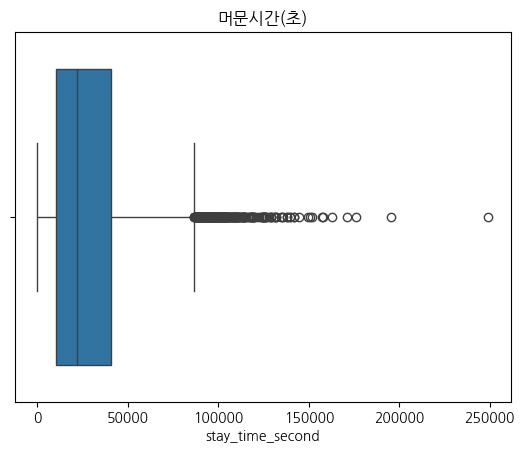

In [38]:
# 박스플롯으로 이상치 확인
sns.boxplot(data=user_stay_sum, x='stay_time_second')
plt.title('머문시간(초)')
plt.show()

In [39]:
user_stay_sum.describe()

,stay_time_second
count,6534.000000
mean,29199.869299
std,25507.140482
min,9.000000
25%,10465.250000
50%,21696.000000
75%,40861.750000
max,249203.000000


- 최대 머문시간 : 2일 21시간 13분 23초
- 최소 머문시간 : 9초

- 한유저당 머문시간 총합이 900초 이하면 제외 > 15분 이하는 체험에 의한 결정상관이 없을것으로 판단

In [40]:
# 15분이하로 머문 유저 정의
user_under = user_stay_sum[user_stay_sum['stay_time_second'] <= 900]

In [41]:
# 내림차순으로 확인
# 너무 높은 수치로 e5e8feb2-5c4f-4b48-899d-f46d7a484d58 해당 유저만 제외
user_stay_sum.sort_values(by='stay_time_second', ascending=False).head(15)

,user_uuid,stay_time_second
5871,e5e8feb2-5c4f-4b48-899d-f46d7a484d58,249203
5162,c9fb93af-63dc-48a2-ac11-bfa995bda87d,195305
2564,62e10dea-aeed-4c2e-a3f1-94bb0bcbbd15,176127
423,0ed8949e-f781-4f90-bec9-80c00f77f361,171005
1937,4acf941b-b706-4891-a592-7e04784a1cc4,162920
2548,62249fbd-006c-418e-b03d-886fcb3096d6,157969
4761,b8fd4306-26b8-44b8-a648-669871fe3afb,157098
1220,2d3f3383-f77e-4be2-a198-620286406562,151548
607,15914f78-b2b4-4692-ae8d-de2fe6a43a27,150607
5963,e943b258-c5c1-49f3-b63a-92ce69e15779,149344


In [42]:
# 15분 이하 유저 리스트
user_under_list = user_stay_sum[user_stay_sum['stay_time_second'] <= 900]['user_uuid'].tolist()

# 15분 이하 유저 + 너무 오래머문 이상치 e5e8feb2-5c4f-4b48-899d-f46d7a484d58
exclude_users = user_under_list + ['e5e8feb2-5c4f-4b48-899d-f46d7a484d58']

# 제외해서 필터링
filtered_visit = filter_visit_cleaned[~filter_visit_cleaned['user_uuid'].isin(exclude_users)]

In [43]:
filtered_visit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11305 entries, 0 to 11476
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   site_id           11305 non-null  int64         
 1   date              11305 non-null  object        
 2   stay_time         11305 non-null  object        
 3   stay_time_second  11305 non-null  int64         
 4   first_enter_time  10759 non-null  datetime64[ns]
 5   last_leave_time   10759 non-null  datetime64[ns]
 6   user_uuid         11305 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 706.6+ KB


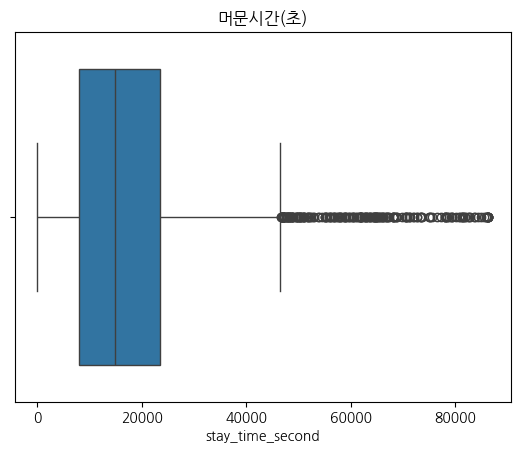

In [44]:
# 박스플롯으로 이상치 확인
sns.boxplot(data=filtered_visit, x='stay_time_second')
plt.title('머문시간(초)')
plt.show()

In [45]:
# 결측치 제외
filtered_visit_drop = filtered_visit.copy()
filtered_visit_drop.dropna(inplace=True)
filtered_visit_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10759 entries, 0 to 11476
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   site_id           10759 non-null  int64         
 1   date              10759 non-null  object        
 2   stay_time         10759 non-null  object        
 3   stay_time_second  10759 non-null  int64         
 4   first_enter_time  10759 non-null  datetime64[ns]
 5   last_leave_time   10759 non-null  datetime64[ns]
 6   user_uuid         10759 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 672.4+ KB


### 여러군데 방문칼럼 추가

- 한군데만 방문한 체험인원: 1, 2곳이상 방문한 체험인원: 2

In [46]:
# 1. user_uuid별 site_id 고유 개수 세기
site_count = filtered_visit_drop.groupby('user_uuid')['site_id'].nunique().reset_index()

# 2. 2개 이상 방문했으면 1, 아니면 0
site_count['multi_site_user'] = (site_count['site_id'] >= 2).astype(int)

# 3. 병합 전 혹시라도 기존에 multi_site_user 컬럼이 있으면 제거
filtered_visit_drop = filtered_visit_drop.drop(columns=['multi_site_user'], errors='ignore')

# 4. site_count에서 필요한 컬럼만 붙이기
filtered_visit_drop2 = filtered_visit_drop.merge(
    site_count[['user_uuid', 'multi_site_user']],
    on='user_uuid',
    how='left'
)

In [47]:
filtered_visit_drop2.head()

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid,multi_site_user
0,1,2023-12-23,01:11:19.983486,4279,2023-12-23 16:11:25,2023-12-23 17:25:32,939fc566-61cd-47f0-a3ce-e2936fdcff73,0
1,1,2023-12-24,04:35:10.361341,16510,2023-12-24 16:10:45,2023-12-24 20:53:34,939fc566-61cd-47f0-a3ce-e2936fdcff73,0
2,1,2023-12-25,02:09:54.117163,7794,2023-12-25 10:19:47,2023-12-25 12:39:51,939fc566-61cd-47f0-a3ce-e2936fdcff73,0
3,1,2023-12-23,04:37:36.134901,16656,2023-12-23 14:49:40,2023-12-23 19:27:39,ba49324f-d317-4053-adf9-2b17b3f07594,1
4,3,2023-12-26,04:32:05.289251,16325,2023-12-26 14:57:10,2023-12-26 19:34:36,ba49324f-d317-4053-adf9-2b17b3f07594,1


In [48]:
filtered_visit_drop2['multi_site_user'].value_counts()

,count
multi_site_user,
0,10019
1,740


In [49]:
filtered_visit_drop2['user_uuid'].nunique()

6095

### site_id 면적별 맵핑

In [50]:
filtered_visit_area = filtered_visit_drop2.copy()
filtered_visit_area.tail(1)

,site_id,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid,multi_site_user
10758,6,2022-04-20,07:48:04.922610,28084,2022-04-20 13:24:06,2022-04-20 23:59:59,ac90eb79-233a-47e0-99c7-c8f7b8372a57,0


In [51]:
area_df.head(15)

,site_id,area_pyeong
0,1,50
1,2,100
2,3,150
3,4,100
4,5,150
5,6,150
6,17,50
7,47,50
8,49,50


In [52]:
# site_id를 면적별로 맵핑
area = {
    1: 50,
    2: 100,
    3: 150,
    4: 100,
    5: 150,
    6: 150,
    17: 50,
    47: 50,
    49: 50
        }

In [53]:
# 칼럼명 변경
filtered_visit_area.rename(columns={'site_id':'site_area'}, inplace=True)

In [54]:
# 맵핑 데이터 적용
filtered_visit_area['site_area'] = filtered_visit_area['site_area'].replace(area)
filtered_visit_area['site_area'].unique()

array([ 50, 150, 100])

In [55]:
filtered_visit_area.tail(2)

,site_area,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid,multi_site_user
10757,150,2023-02-06,06:30:29.693768,23429,2023-02-06 10:14:00,2023-02-06 16:52:37,576473bb-0647-483e-b06a-a5ff6491b08b,0
10758,150,2022-04-20,07:48:04.922610,28084,2022-04-20 13:24:06,2022-04-20 23:59:59,ac90eb79-233a-47e0-99c7-c8f7b8372a57,0


In [56]:
filtered_visit_area['user_uuid'].nunique()

6095

In [57]:
filtered_visit_area[filtered_visit_area['user_uuid'] == 'acf3e288-4487-492b-9477-df149fb72e83']

,site_area,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid,multi_site_user
95,150,2024-01-01,04:02:05.462200,14525,2024-01-01 12:05:16,2024-01-01 16:09:01,acf3e288-4487-492b-9477-df149fb72e83,0
96,150,2023-12-31,06:36:57.019750,23817,2023-12-31 11:12:56,2023-12-31 18:56:40,acf3e288-4487-492b-9477-df149fb72e83,0


In [58]:
area_counts = filtered_visit_area.groupby('user_uuid')['site_area'].nunique()

In [59]:
# 유저별 여러지점 방문 확인
multi_area_users = area_counts[area_counts > 1].index
result = filtered_visit_area[filtered_visit_area['user_uuid'].isin(multi_area_users)]

In [60]:
result

,site_area,date,stay_time,stay_time_second,first_enter_time,last_leave_time,user_uuid,multi_site_user
3,50,2023-12-23,04:37:36.134901,16656,2023-12-23 14:49:40,2023-12-23 19:27:39,ba49324f-d317-4053-adf9-2b17b3f07594,1
4,150,2023-12-26,04:32:05.289251,16325,2023-12-26 14:57:10,2023-12-26 19:34:36,ba49324f-d317-4053-adf9-2b17b3f07594,1
5,150,2023-12-25,05:51:31.276580,21091,2023-12-25 14:38:26,2023-12-25 20:29:58,ba49324f-d317-4053-adf9-2b17b3f07594,1
21,50,2023-12-30,00:51:57.850973,3117,2023-12-30 18:47:02,2023-12-30 19:41:23,e80f7f66-f24a-4637-95c9-20288fd811ee,1
22,100,2024-01-01,00:55:41.445430,3341,2024-01-01 17:39:42,2024-01-01 18:38:05,e80f7f66-f24a-4637-95c9-20288fd811ee,1
...,...,...,...,...,...,...,...,...
10463,100,2022-06-18,02:02:17.319063,7337,2022-06-18 13:51:27,2022-06-18 15:53:44,15c1f928-b003-4cba-81bc-2a581f6e2e89,1
10487,50,2022-04-02,01:25:03.204235,5103,2022-04-02 16:04:02,2022-04-02 17:29:06,3533164f-1c7b-4432-a8ff-96f0a1c0ce00,1
10488,150,2022-04-02,00:59:09.125067,3549,2022-04-02 18:21:56,2022-04-02 19:23:56,3533164f-1c7b-4432-a8ff-96f0a1c0ce00,1
10693,150,2022-08-08,07:23:07.919950,26587,2022-08-08 11:15:39,2022-08-08 19:44:43,c1f2194a-45a5-4421-b5f5-c806f6c4bfb6,1


- 어느 지점을 결제했는지 데이터가 없기 때문에 'site_area' 칼럼은 결제에 영향을 줬다고 판단하기 어려움

In [61]:
# site_area 칼럼 제거
filtered_visit_area.drop(columns='site_area', inplace=True)

In [62]:
visitend_df = filtered_visit_area.copy()

In [63]:
# stay_time_second를 합산했을 때, 묶이지 않는 칼럼제거
visitend_df.drop(columns=['date', 'stay_time', 'last_leave_time'], inplace=True)

In [64]:
visit_summary = visitend_df.groupby('user_uuid').agg({
    'stay_time_second': 'sum',
    'first_enter_time': 'min',
    'multi_site_user': 'max'
}).reset_index()

In [65]:
visit_summary.head()

,user_uuid,stay_time_second,first_enter_time,multi_site_user
0,000590dc-046f-462b-8225-4c81a97b7166,21417,2023-09-05 11:57:01,0
1,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,45569,2021-09-30 16:31:14,0
2,0018e22d-a2cc-4e06-bca2-d6a041770f3b,77372,2023-11-15 09:44:07,0
3,002606d9-38ca-48f3-910c-cbfada9a9109,25024,2023-01-07 17:25:54,0
4,002a7570-90dd-4cab-b0aa-b0e40f7ef27a,23609,2021-09-08 16:37:24,0


In [66]:
visit_summary['user_uuid'].nunique()

6095

## 결제이력

In [67]:
pay_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   is_payment  9659 non-null   int64 
 1   user_uuid   9659 non-null   object
dtypes: int64(1), object(1)
memory usage: 151.1+ KB


In [68]:
pay_duple = pay_df[pay_df.duplicated(subset=None, keep=False)]
pay_duple

,is_payment,user_uuid
17,0,56231301-3408-4206-962d-aaa25a342821
18,0,56231301-3408-4206-962d-aaa25a342821
21,0,4c5b26a3-24d4-4b8f-a591-be80271c0aeb
22,0,4c5b26a3-24d4-4b8f-a591-be80271c0aeb
27,0,204ecb60-f9e3-42b4-ae7a-f1f00c939894
...,...,...
6903,0,969e4e79-950b-4608-90da-ac26aed52d55
6904,1,dceba5c8-20c2-497a-829a-74099f7ee5a8
6905,1,dceba5c8-20c2-497a-829a-74099f7ee5a8
6906,1,7c5f0d06-2b1a-4a47-8961-3f93813b4eb7


In [69]:
pay_cleaned = pay_df.drop_duplicates(subset=None, keep='first')
pay_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9624 entries, 0 to 9658
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   is_payment  9624 non-null   int64 
 1   user_uuid   9624 non-null   object
dtypes: int64(1), object(1)
memory usage: 225.6+ KB


### visit + pay

In [70]:
visit_summary_pay = pd.merge(visit_summary, pay_cleaned, on='user_uuid', how='inner')
visit_summary_pay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6095 entries, 0 to 6094
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_uuid         6095 non-null   object        
 1   stay_time_second  6095 non-null   int64         
 2   first_enter_time  6095 non-null   datetime64[ns]
 3   multi_site_user   6095 non-null   int64         
 4   is_payment        6095 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 238.2+ KB


In [71]:
visit_summary_pay.head()

,user_uuid,stay_time_second,first_enter_time,multi_site_user,is_payment
0,000590dc-046f-462b-8225-4c81a97b7166,21417,2023-09-05 11:57:01,0,0
1,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,45569,2021-09-30 16:31:14,0,1
2,0018e22d-a2cc-4e06-bca2-d6a041770f3b,77372,2023-11-15 09:44:07,0,0
3,002606d9-38ca-48f3-910c-cbfada9a9109,25024,2023-01-07 17:25:54,0,0
4,002a7570-90dd-4cab-b0aa-b0e40f7ef27a,23609,2021-09-08 16:37:24,0,1


In [72]:
(visit_summary_pay['is_payment'] == 0).sum()

np.int64(3732)

In [73]:
(visit_summary_pay['is_payment'] == 1).sum()

np.int64(2363)

In [74]:
visit_summary_pay['user_uuid'].nunique()

6095

In [75]:
visit_summary_pay['hour'] = visit_summary_pay['first_enter_time'].dt.hour

In [76]:
visit_summary_pay.head()

,user_uuid,stay_time_second,first_enter_time,multi_site_user,is_payment,hour
0,000590dc-046f-462b-8225-4c81a97b7166,21417,2023-09-05 11:57:01,0,0,11
1,000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,45569,2021-09-30 16:31:14,0,1,16
2,0018e22d-a2cc-4e06-bca2-d6a041770f3b,77372,2023-11-15 09:44:07,0,0,9
3,002606d9-38ca-48f3-910c-cbfada9a9109,25024,2023-01-07 17:25:54,0,0,17
4,002a7570-90dd-4cab-b0aa-b0e40f7ef27a,23609,2021-09-08 16:37:24,0,1,16


# 상관관계 분석

In [77]:
visit_summary_pay2 = visit_summary_pay.copy()

In [78]:
visit_summary_pay2.drop(columns=['user_uuid', 'first_enter_time'], inplace=True)

In [79]:
corr_with_pay = visit_summary_pay2.corr()['is_payment'].sort_values(ascending=False)
corr_with_pay

,is_payment
is_payment,1.000000
hour,0.081072
multi_site_user,0.046961
stay_time_second,-0.022252


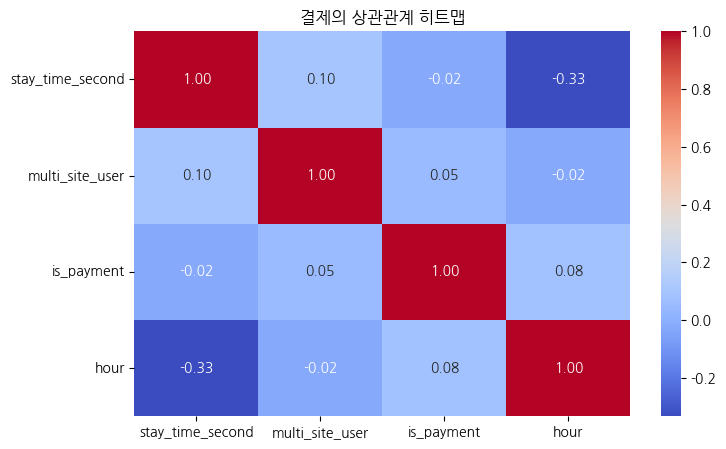

In [80]:
plt.figure(figsize=(8, 5))
sns.heatmap(visit_summary_pay2.corr(), annot=True, fmt='.2f', cmap='coolwarm')

plt.title('결제의 상관관계 히트맵')
plt.show()

# 모델 적용

## LinearRegression 모델

In [81]:
X = visit_summary_pay2.drop(columns='is_payment')
y = visit_summary_pay2['is_payment']

In [82]:
# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

In [83]:
# 모델학습
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [84]:
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.3f}')
print(f'R2: {r2:.3f}')

RMSE: 0.483
R2: 0.008


- 역시 선형회귀는 설명력이 너무 낮다 -> 선형은 절대아님으로 판단
- Y가 0, 1 로 이진분류 모델을 써야할듯으로 판단
- LogisticRegression, DecisionTreeClassifier, RandomForestClassifier

## 결정트리 모델

In [85]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

In [86]:
X = visit_summary_pay2.drop(columns='is_payment')
y = visit_summary_pay2['is_payment']

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

In [87]:
# 모델 학습
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [88]:
# 모델 평가
y_pred = tree.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'acc score: {acc:.3f}')

acc score: 0.529


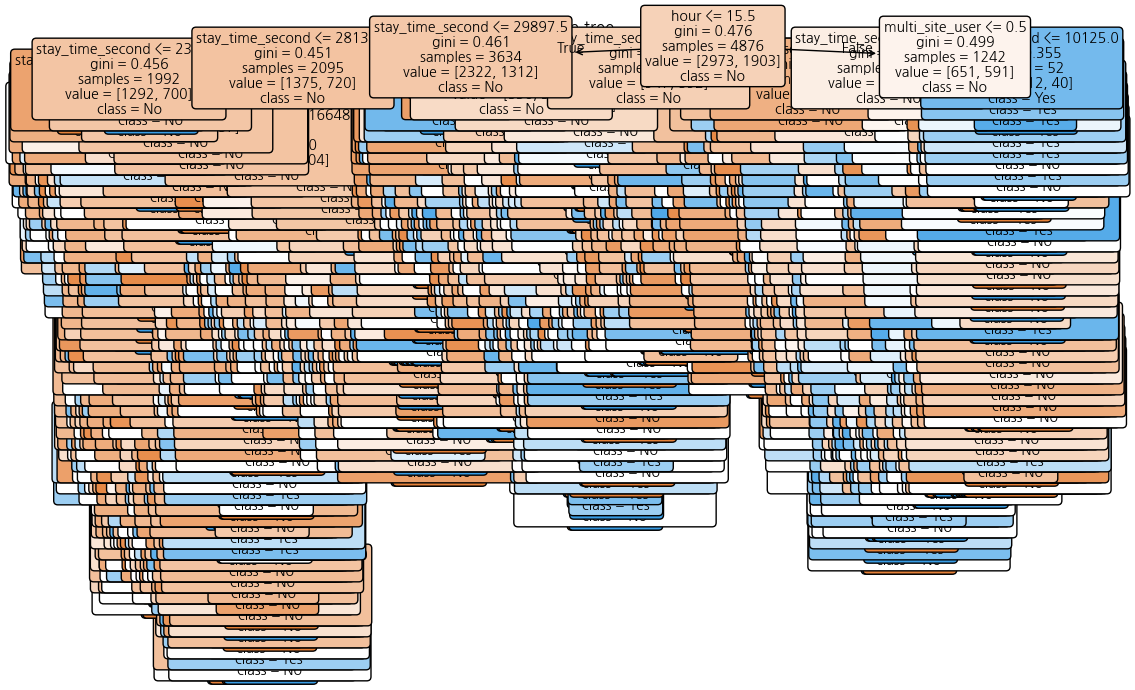

In [89]:
# 트리 결과 시각화
plt.figure(figsize=(12, 8))
plot_tree(tree,
          feature_names=X_train.columns.tolist(),
          class_names=['No', 'Yes'],
          filled=True,
          rounded=True,
          fontsize=10
          )
plt.title('decision tree')
plt.show()

In [90]:
# 트리가 너무 복잡 -> 하이퍼파라미터 실험
# 실험할 하이퍼파라미터 값
depths = [2, 3, 5, 7, 10, 20, 30]
splits = [2, 10, 20, 30, 60, 80, 200]
leaves = [1, 2, 3, 5, 10, 15]

In [91]:
# 깊이에 따른 모델 정확도 비교
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=25)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'accuracy: {acc:.3f}')

accuracy: 0.622
accuracy: 0.622
accuracy: 0.618
accuracy: 0.617
accuracy: 0.609
accuracy: 0.578
accuracy: 0.543


- depths가 적을수록 정확

In [92]:
# 분할 샘플에 따른 모델 정확도 비교
for s in splits:
    clf = DecisionTreeClassifier(min_samples_split=s, random_state=24)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'accuracy: {acc:.3f}')

accuracy: 0.533
accuracy: 0.558
accuracy: 0.559
accuracy: 0.553
accuracy: 0.582
accuracy: 0.585
accuracy: 0.602


In [93]:
# 리프 수 기준에 따른 모델 정확도 비교
for leaf in leaves:
    clf = DecisionTreeClassifier(min_samples_leaf=leaf, random_state=24)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'accuracy: {acc:.3f}')

accuracy: 0.533
accuracy: 0.572
accuracy: 0.548
accuracy: 0.572
accuracy: 0.552
accuracy: 0.548


In [94]:
# 하이퍼파라미터 적용 모델 학습
tree = DecisionTreeClassifier(
    max_depth = 3,
    min_samples_split = 200,
    min_samples_leaf = 5,
)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, min_samples_split=200)

In [95]:
# 모델 평가
y_pred = tree.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'acc score: {acc:.3f}')

acc score: 0.622


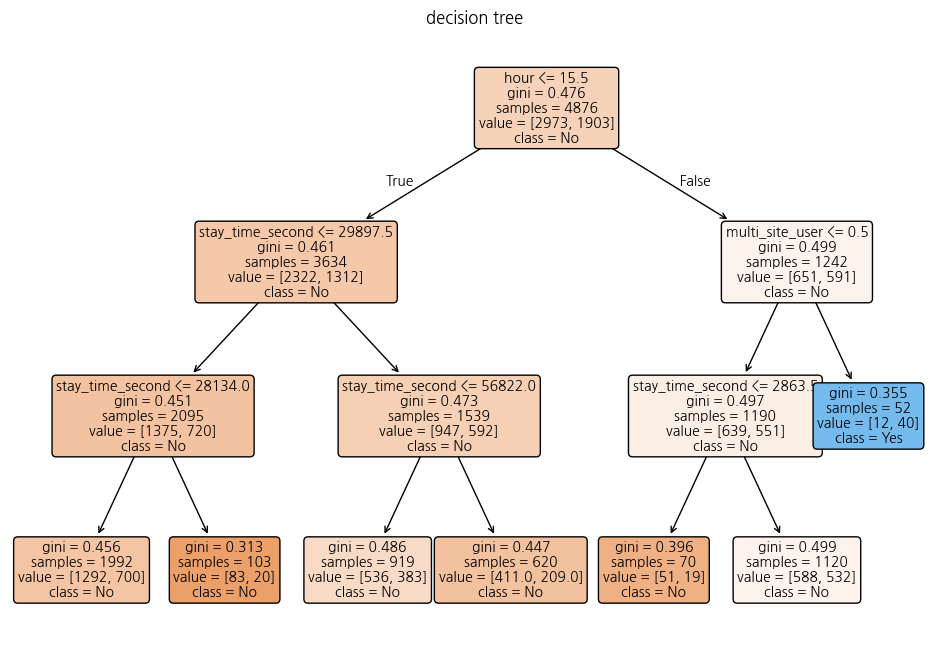

In [96]:
# 트리 결과 시각화
plt.figure(figsize=(12, 8))
plot_tree(tree,
          feature_names=X_train.columns.tolist(),
          class_names=['No', 'Yes'],
          filled=True,
          rounded=True,
          fontsize=10
          )
plt.title('decision tree')
plt.show()

- multi_site_user 가 마지막 리프노드 전에 조건으로 확인된것으로 multi_site_user<=0.5 로 유저들이 한곳만 방문한 사람들이 결제할 확률이 높다고 판단
- 하지만 정확도가 낮고 지니계수가 완전히 분리된게 아니라서 다른 모델을 써봐야할 것으로 생각

## 랜덤포레스트 모델

In [97]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    oob_score=True
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
acc_rf = accuracy_score(y_test, rf_pred)

In [98]:
print(f'랜덤포레스트 모델 정확도:{acc_rf:.3f}')

랜덤포레스트 모델 정확도:0.518


### 그리드 서치

- 랜덤포레스트 모델도 정확도가 높지 않아 그리드 서치로 하이퍼파라미터 찾기

In [99]:
# 설정할 하이퍼파라미터 값을 딕셔너리 형태로 선언
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 3]
}

In [100]:
# 모델준비
rf = RandomForestClassifier(n_jobs=-1, random_state=25)

In [101]:
from sklearn.model_selection import GridSearchCV

In [102]:
gs = GridSearchCV(
    rf,
    param_grid=param_grid, # 리스트값을 가지는 딕셔너리 형태
    cv=5, # cross validation 교차검증
    scoring='accuracy', # 예측 성능 지표 설정
    n_jobs=-1, # cpu 성능최대
    refit=True, # 최적의 하이퍼파라미터를 찾은 뒤 해당값으로 재학습
    verbose=1 # 학습 과정 출력 정도(0, 1, 2) -> 0은 출력안함 1은 어느정도 출력 2는 자세히 출력
)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=25),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10], 'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 10],
                         'n_estimators': [100, 300]},
             scoring='accuracy', verbose=1)

In [103]:
best_rf = gs.best_estimator_
best_pred = best_rf.predict(X_test)

In [104]:
best_acc = accuracy_score(y_test, best_pred)
print(f'베스트 정확도:{best_acc:.3f}')

베스트 정확도:0.632


In [105]:
feat_names = X_train.columns.tolist()

In [106]:
# 피처 중요도를 시리즈 데이터 타입으로 저장
# corr 즉 상관관계랑은 좀 다르다
# 모델학습에 중요한 역할을 한 것들
importances = pd.Series(best_rf.feature_importances_, index=feat_names).sort_values(ascending=False)

In [107]:
# 상위 10개 시각화
top_n = 10
top_importances = importances.head(top_n)

<Axes: >

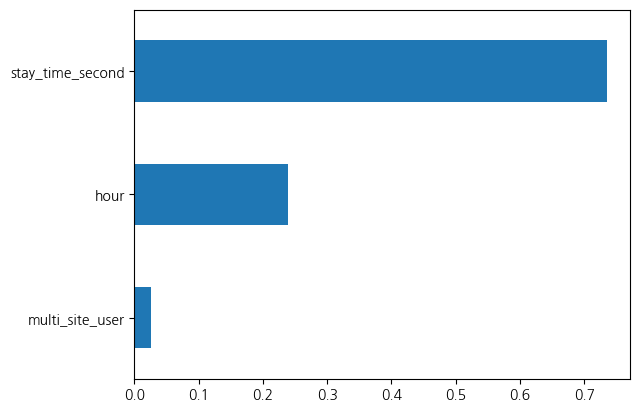

In [108]:
# 역순으로 그려서 가장 큰 값이 위로 가도록 설정
top_importances.iloc[::-1].plot(kind='barh')

In [109]:
top_importances

,0
stay_time_second,0.735057
hour,0.239305
multi_site_user,0.025638


In [110]:
b_rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    oob_score=True,
    max_depth=10,
    min_samples_leaf=3,
    random_state=25
)

b_rf.fit(X_train, y_train)
b_rf_pred = b_rf.predict(X_test)
acc_b_rf = accuracy_score(y_test, b_rf_pred)

print(f'베스트 정확도:{acc_b_rf:.3f}')

베스트 정확도:0.632


In [112]:
from sklearn.metrics import classification_report

In [113]:
# 테스트 데이터에 대해 예측 및 성능 평가
b_rf_pred = b_rf.predict(X_test)
print(classification_report(y_test, b_rf_pred))

              precision    recall  f1-score   support

           0       0.65      0.91      0.75       759
           1       0.54      0.18      0.27       460

    accuracy                           0.63      1219
   macro avg       0.59      0.54      0.51      1219
weighted avg       0.61      0.63      0.57      1219



In [114]:
b_rf2 = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    oob_score=True,
    max_depth=10,
    min_samples_leaf=3,
    random_state=25,
    class_weight='balanced'
)

b_rf2.fit(X_train, y_train)
b_rf_pred2 = b_rf.predict(X_test)
acc_b_rf2 = accuracy_score(y_test, b_rf_pred2)

print(f'베스트 정확도:{acc_b_rf2:.3f}')

베스트 정확도:0.632


In [115]:
# 테스트 데이터에 대해 예측 및 성능 평가
b_rf_pred2 = b_rf2.predict(X_test)
print(classification_report(y_test, b_rf_pred2))

              precision    recall  f1-score   support

           0       0.65      0.62      0.64       759
           1       0.42      0.44      0.43       460

    accuracy                           0.56      1219
   macro avg       0.53      0.53      0.53      1219
weighted avg       0.56      0.56      0.56      1219



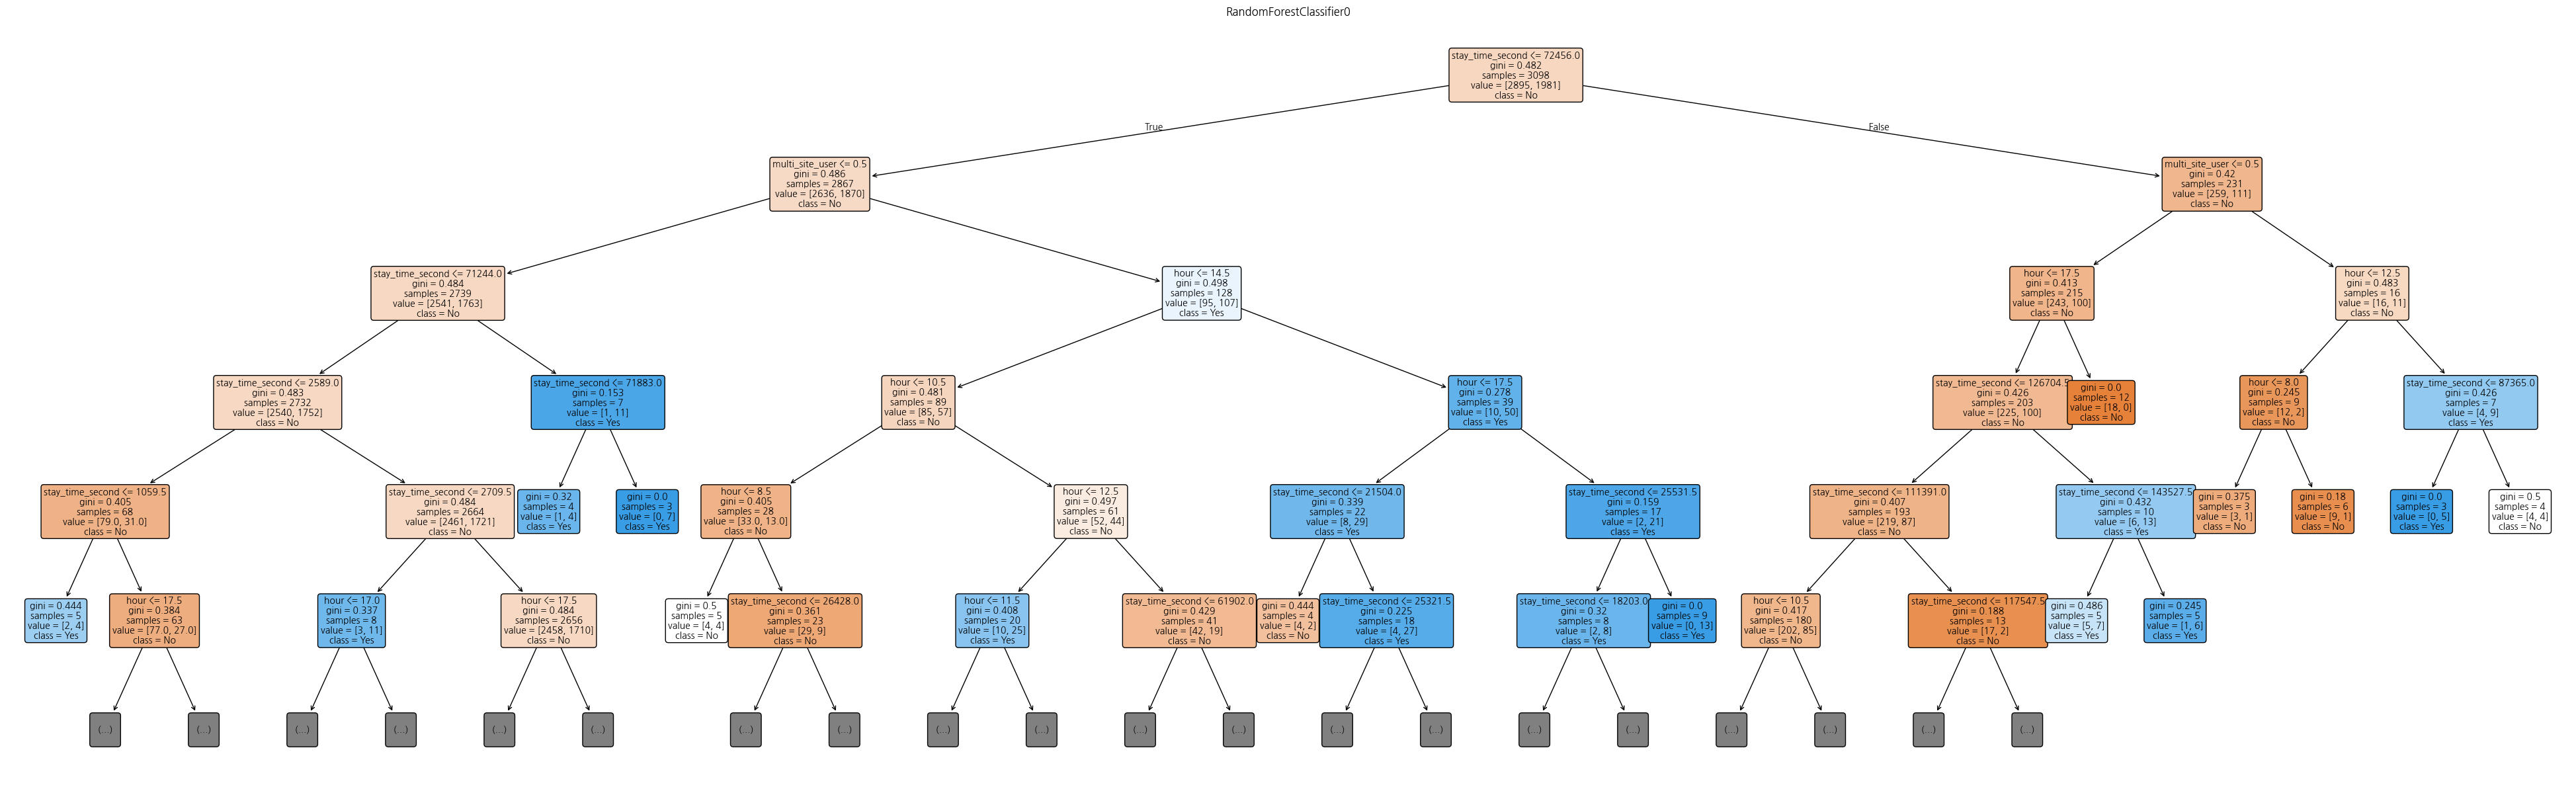

In [116]:
# 트리 결과 시각화

estimator = b_rf.estimators_[0]

plt.figure(figsize=(50, 15))
plot_tree(estimator,
          feature_names=X_train.columns.tolist(),
          class_names=['No', 'Yes'],
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=5
          )
plt.title('RandomForestClassifier0')
plt.show()

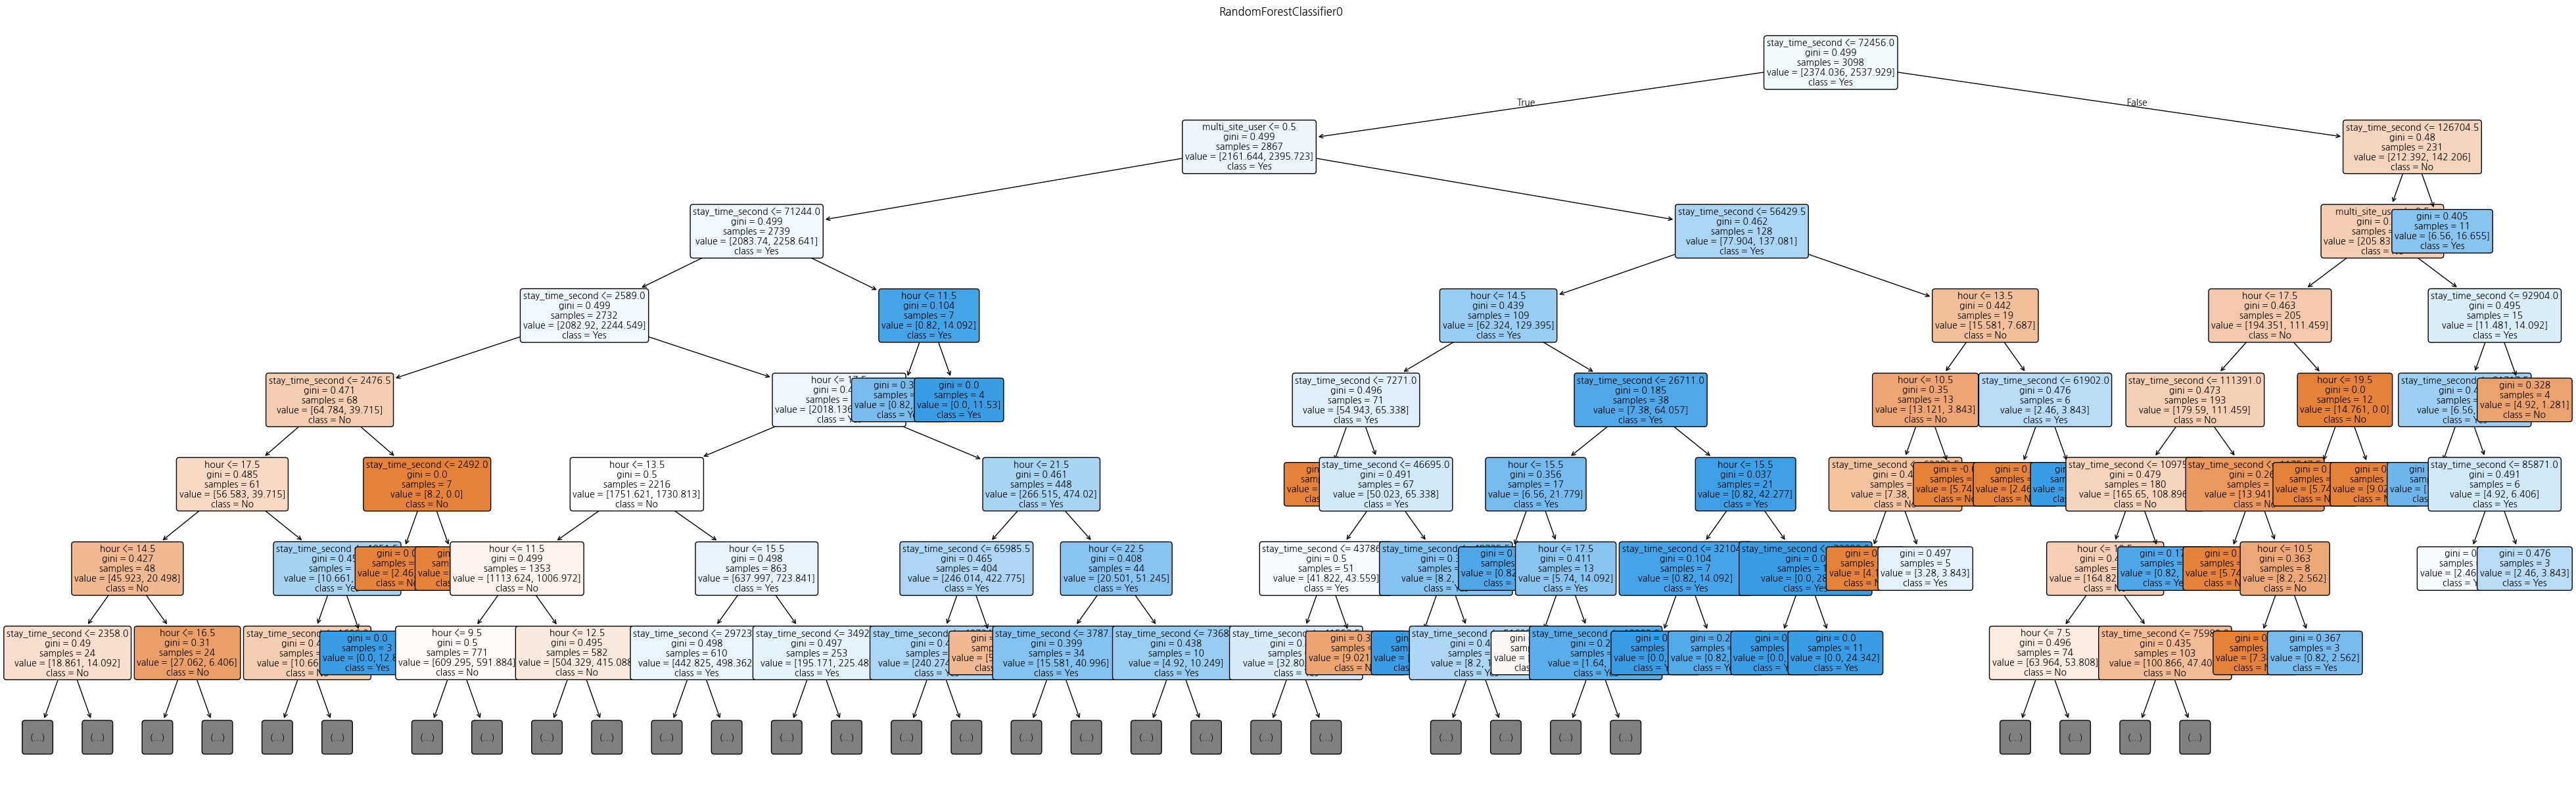

In [137]:
# 트리 결과 시각화

estimator2 = b_rf2.estimators_[0]

plt.figure(figsize=(50, 15))
plot_tree(estimator2,
          feature_names=X_train.columns.tolist(),
          class_names=['No', 'Yes'],
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=7
          )
plt.title('RandomForestClassifier0')
plt.show()

RandomForestClassifier1
- 정확도 약 63%
- 17.5시 이전에 첫방문한 유저들이 결제할 확률이 높다(지니계수 0.278)
- 머문시간이 20시간 밑으로 머문 유저들이 결제할 확률이 높다(지니계수 0.153)
- 머문시간이 7시간 밑으로 머문 유저들이 결제할 확률이 높다(지니계수 0.159)
- 8시 이전에 첫방문한 유저들이 결제할 확률이 낮다(지니계수 0.245)

- 여러지점을 방문한 것은 모델에 큰 영향을 주지 않고 유저별 총 머문시간이 영향을 크게 미친다  

In [117]:
from sklearn.metrics import f1_score

# 최적 모델을 이용해 예측
y_pred = b_rf.predict(X_test)

# F1 스코어 계산 (이진 분류 기준)
f1 = f1_score(y_test, y_pred)

print(f"F1 Score: {f1:.3f}")

F1 Score: 0.273


### 혼동행렬

In [118]:
from sklearn.metrics import (
    accuracy_score, confusion_matrix
)

In [119]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[687,  72],
       [376,  84]])

In [120]:
acc = accuracy_score(y_test, y_pred)
print(f'acc: {acc}')

acc: 0.6324856439704676


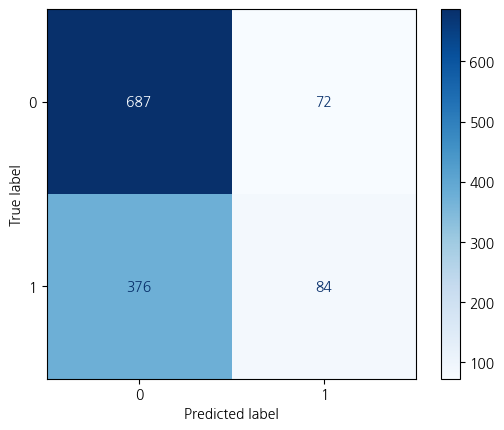

In [121]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.show()

- 실제음성을 음성으로 예측하는 비율이 높다
- 따라서 class=NO 인 부분도 전략에 포함시켜서 확인

## XGBoost 모델

In [122]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report

# XGBoost 모델 생성
xgb_model = XGBClassifier(
    max_depth=10,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=25,
    scale_pos_weight=4,
    use_label_encoder=False,
    eval_metric='logloss'  # 경고 방지용
)

# 학습
xgb_model.fit(X_train, y_train)

# 예측
y_pred = xgb_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:04:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [123]:
# F1 스코어
f1 = f1_score(y_test, y_pred)
print(f"XGBoost F1 Score: {f1:.4f}")

XGBoost F1 Score: 0.5311


# 클러스터 분석

In [124]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

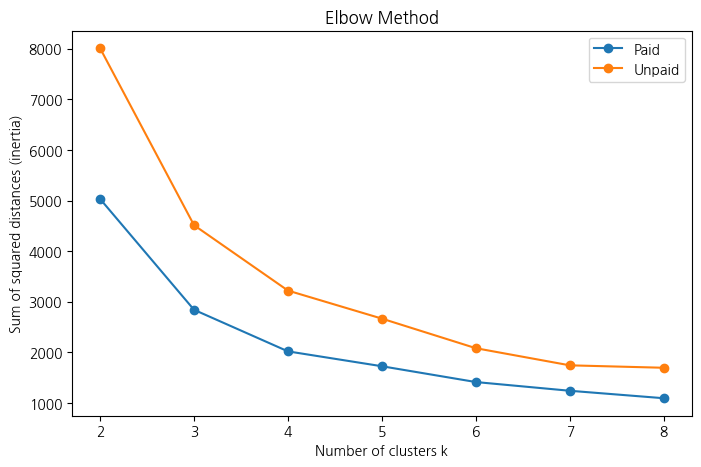

In [125]:
# 1. 데이터 분리
df = visit_summary_pay2.copy()
paid = df[df['is_payment'] == 1].drop(columns=['is_payment'])
unpaid = df[df['is_payment'] == 0].drop(columns=['is_payment'])

# 2. 피처 스케일링
scaler = StandardScaler()
X_paid = scaler.fit_transform(paid)
X_unpaid = scaler.fit_transform(unpaid)

# 3. 최적 클러스터 개수(k) 찾기 — 엘보우 방법
def find_k(X, name):
    sse = []
    K = range(2, 9)
    for k in K:
        sse.append(KMeans(n_clusters=k, random_state=42).fit(X).inertia_)
    plt.plot(K, sse, marker='o', label=name)

plt.figure(figsize=(8, 5))
find_k(X_paid, 'Paid')
find_k(X_unpaid, 'Unpaid')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distances (inertia)')
plt.legend()
plt.title('Elbow Method')
plt.show()

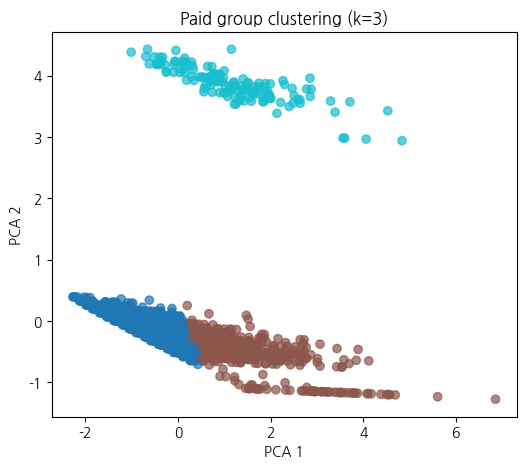

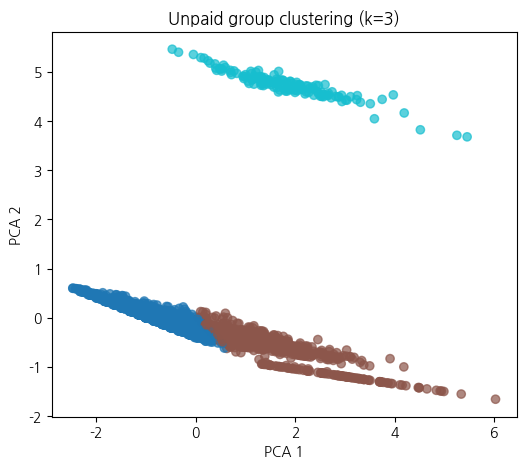

In [126]:
# 4. 클러스터링 및 PCA 시각화
def cluster_and_plot(X, name, k):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(X)

    plt.figure(figsize=(6, 5))
    plt.scatter(X2[:, 0], X2[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.title(f'{name} group clustering (k={k})')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()
    return km, labels

# (예시) k=3으로 설정
km_paid, labels_paid = cluster_and_plot(X_paid, 'Paid', k=3)
km_unpaid, labels_unpaid = cluster_and_plot(X_unpaid, 'Unpaid', k=3)

# 5. 결과를 원래 데이터프레임에 병합
df.loc[df['is_payment'] == 1, 'cluster'] = labels_paid
df.loc[df['is_payment'] == 0, 'cluster'] = labels_unpaid

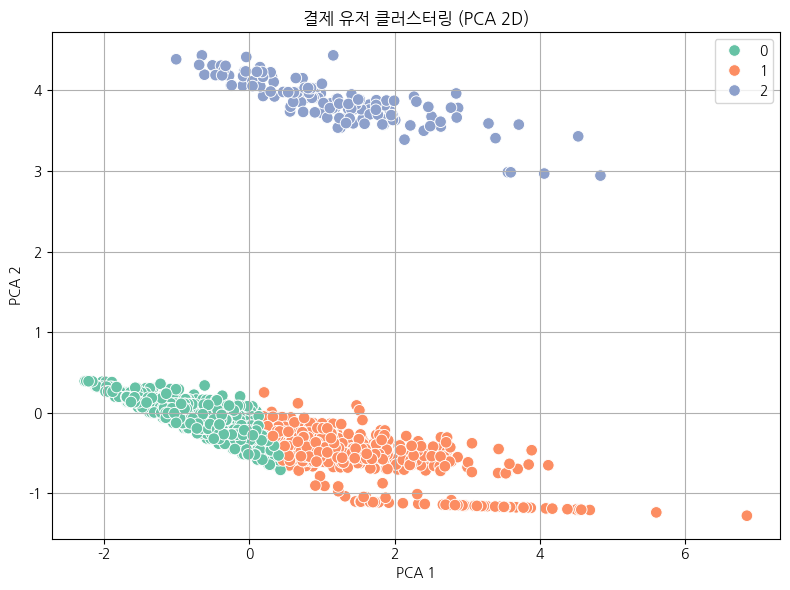

In [127]:
# Paid 그룹에 클러스터 정보 병합
paid['cluster'] = labels_paid

# PCA 적용
pca = PCA(n_components=2, random_state=42)
X_pca_paid = pca.fit_transform(X_paid)

# 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca_paid[:, 0], y=X_pca_paid[:, 1],
                hue=paid['cluster'].astype(int),
                palette='Set2', s=70)

plt.title('결제 유저 클러스터링 (PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [128]:
# 클러스터별 평균값 요약
paid_cluster_summary = paid.groupby('cluster').mean(numeric_only=True).round(2)

# 보기 좋게 출력
display(paid_cluster_summary)

,stay_time_second,multi_site_user,hour
cluster,,,
0,16603.26,0.0,15.26
1,55145.18,0.0,10.04
2,39354.86,1.0,13.48


In [129]:
paid['cluster'].value_counts()

,count
cluster,
0,1546
1,681
2,136


In [130]:
paid2 = paid.copy()

In [131]:
paid2.drop(columns='cluster', inplace=True)

In [132]:
# 군집 특성을 파악하기 위해 로딩확인
# PCA
pca = PCA(n_components=3)
pca.fit(paid2)

# PC1의 로딩 확인
loadings = pca.components_[0]  # PC1 벡터
for var, loading in zip(paid2.columns, loadings):
    print(f"{var}: {loading}")

stay_time_second: 0.9999999980752288
multi_site_user: 9.760791058402581e-07
hour: -6.203700167249815e-05


- 가격에 관련된건 양수값, 디자인에 관련된 변수는 음수면
- 고로 가격과 디자인에 대한 차이가 크다
- PCA1 = 체류시간 + 멀티유저 - hour

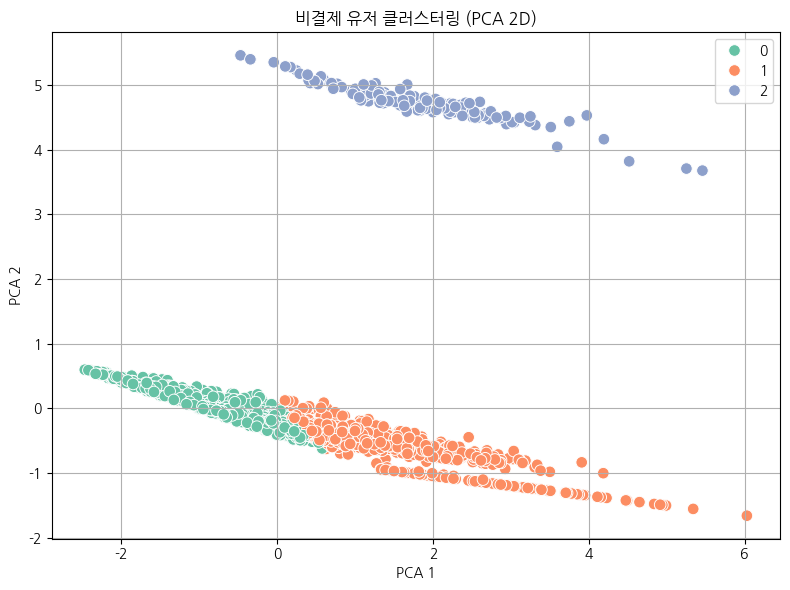

In [133]:
# unpaid 그룹에 클러스터 정보 병합
unpaid['cluster'] = labels_unpaid

# PCA 적용
pca = PCA(n_components=2, random_state=42)
X_pca_unpaid = pca.fit_transform(X_unpaid)

# 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca_unpaid[:, 0], y=X_pca_unpaid[:, 1],
                hue=unpaid['cluster'].astype(int),
                palette='Set2', s=70)

plt.title('비결제 유저 클러스터링 (PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [134]:
# 클러스터별 평균값 요약
unpaid_cluster_summary = unpaid.groupby('cluster').mean(numeric_only=True).round(2)

# 보기 좋게 출력
display(unpaid_cluster_summary)

,stay_time_second,multi_site_user,hour
cluster,,,
0,17511.72,0.0,14.36
1,58834.37,0.0,9.74
2,42182.16,1.0,12.11


In [135]:
unpaid['cluster'].value_counts()

,count
cluster,
0,2532
1,1060
2,140


# 마무리

- 추가 보완점
    - 지점과 결제의 상관관계를 추가로 분석하기 위한 결제했는지 site_id 별 결제 데이터 수집
    - 인구통계학적 데이터를 추가로 수집한다면 유저들의 행동패턴을 세세하게 분석할 수 있을 것